<a href="https://colab.research.google.com/github/BoHye0202/Kaggle/blob/main/mnist/TensorFlow_CNN%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
https://github.com/minsuk-heo/deeplearning/blob/master/src/CNN_Tensorflow.ipynb
'''

'\nhttps://github.com/minsuk-heo/deeplearning/blob/master/src/CNN_Tensorflow.ipynb\n'

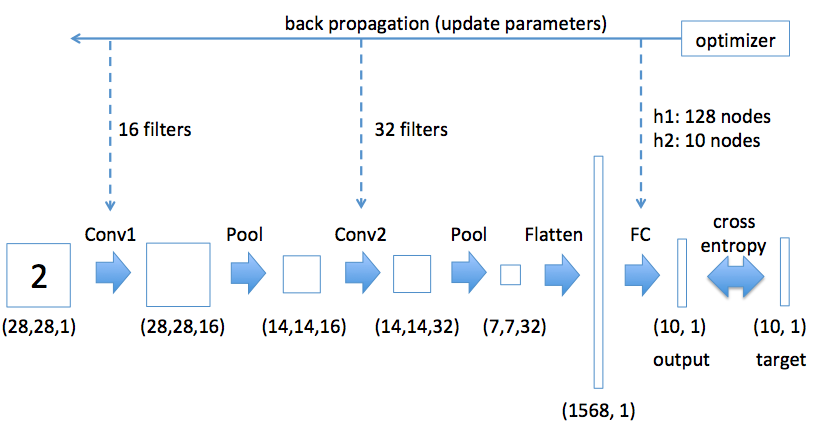

tensorflow가 1.x에서 2.x로 업데이트되면서 session과 placeholder가 사라졌다.

이 문제를 해결하기 위한 2가지 방법이 있는데, 
1. 1.x 버전 사용하기

- `import tensorflow.compat.v1 as tf` 하기
- `tf.compat.v1.disable_eager_execution()` 옵션 넣어주기
- placeholder 사용하기: `x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])`

2. 2.x 버전 사용하기
- `import tensorflow as tf`하기
- `tf.Variable(tf.ones(shape=[None, 28, 28, 1]), dtype=tf.float32)` 형태로 코드 작성하기

In [2]:
# # !pip install tensorflow-gpu==2.0.0-rc1
# !pip install tensorflow==2.2.0

# import tensorflow as tf
import tensorflow.compat.v1 as tf

### collect data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

train data has **60000** samples  
test data has **10000** samples   
every data is **28 * 28** pixels  

below image shows 28*28 pixel image sample for hand written number '0' from MNIST data.  
MNIST is gray scale image [0 to 255] for hand written number.

![0 from MNIST](https://raw.githubusercontent.com/minsuk-heo/deeplearning/master/img/mnist_sample.png)

### Split train data into train and validation data
Split train data into train data and validation data, in order to check validation accuracy.

In [4]:
x_val  = x_train[50000:60000]
x_train = x_train[0:50000]
y_val  = y_train[50000:60000]
y_train = y_train[0:50000]

In [5]:
print("train data has " + str(x_train.shape[0]) + " samples")
print("every train data is " + str(x_train.shape[1]) 
      + " * " + str(x_train.shape[2]) + " image")

train data has 50000 samples
every train data is 28 * 28 image


In [6]:
print("validation data has " + str(x_val.shape[0]) + " samples")
print("every train data is " + str(x_val.shape[1]) 
      + " * " + str(x_train.shape[2]) + " image")

validation data has 10000 samples
every train data is 28 * 28 image


28 * 28 pixels has gray scale value from **0** to **255**

In [7]:
# sample to show gray scale values
print(x_train[0][8])

[  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241
   0   0   0   0   0   0   0   0   0   0]


each train data has its label **0** to **9**

In [8]:
# sample to show labels for first train data to 10th train data
print(y_train[0:9])

[5 0 4 1 9 2 1 3 1]


test data has **10000** samples  
every test data is **28 * 28** image  

In [9]:
print("test data has " + str(x_test.shape[0]) + " samples")
print("every test data is " + str(x_test.shape[1]) 
      + " * " + str(x_test.shape[2]) + " image")

test data has 10000 samples
every test data is 28 * 28 image


### Reshape
We reshape x_train to be fitted in tf model.

In [10]:
import numpy as np
x_train = np.reshape(x_train, (50000,28,28,1))
x_val = np.reshape(x_val, (10000,28,28,1))
x_test = np.reshape(x_test, (10000,28,28,1))

print(x_train.shape)
print(x_test.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)


### Normalize data
normalization usually helps faster learning speed, better performance  
by reducing variance and giving same range to all input features.  
since MNIST data set all input has 0 to 255, normalization only helps reducing variances.  
it turned out normalization is better than standardization for MNIST data with my MLP architeture,    
I believe this is because relu handles 0 differently on both feed forward and back propagation.  
handling 0 differently is important for MNIST, since 1-255 means there is some hand written,  
while 0 means no hand written on that pixel.

In [11]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

gray_scale = 255
x_train /= gray_scale
x_val /= gray_scale
x_test /= gray_scale

### label to one hot encoding value
In order to measure difference between softmax output and target,  
target value need to be one hot encoding.

In [12]:
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Implement CNN tensorflow graph

We use image itself (28 x 28) as input of CNN.
Target will be number between 0 to 9.

In [14]:
# x = tf.Variable(tf.ones(shape=[None, 28, 28, 1]), dtype=tf.float32) # input shpae, None은 몇 개의 샘플을 사용할지 몰라서
# y_ = tf.Variable(tf.ones(shape=[None, 10]), dtype=tf.float32) # output shape

tf.compat.v1.disable_eager_execution()
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

We initialize parameters near 0.  
The point for using **truncated normal** is to overcome saturation of sigmoid in softmax (where if the value is too big/small, the neuron stops learning).  
tf.truncated_normal() selects random numbers from a normal distribution whose mean is close to 0 and values are close to 0 Ex. -0.1 to 0.1.  
It's called truncated because your cutting off the tails from a normal distribution.  
**tf.random_normal()** selects random numbers from a normal distribution whose mean is close to 0; however the values can be a bit further apart. Ex. -2 to 2  

In [15]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1) # tf.random_normal은 random하게 initialize하지만, truncated는 0과 비슷한 값으로 주게 되어있다.
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

**Same padding** means the size of output feature-maps are the same as the input feature-maps.  
For example, our MNIST has (28x28) shape, so the output will also (28,28) shape.

In [16]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') # padding SAME은 input=ouput shape이다.

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

First Convolutional Layer has 16 filters with size 5 by 5.  

In [17]:
W_conv1 = weight_variable([5, 5, 1, 16]) # filter size=5,5 / 처음시작: 1개의 grayscale / 16개의 filter
b_conv1 = bias_variable([16])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


We use Relu activation funtion. Activation function brings non linearity in the model.

In [18]:
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1) # activation = relu

After Convolutional Layer, we apply Pooling layer to reduce activation map size.  
Pooling layer will reduce parameters and control overfitting.

In [19]:
h_pool1 = max_pool_2x2(h_conv1) # size를 절반으로 줄이기

After Max Pooling, now we have (14,14) input shape.  
Here we have second Convolutional layer.

In [20]:
W_conv2 = weight_variable([5, 5, 16, 32]) 
b_conv2 = bias_variable([32])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

After Max Pooling, now we have (7,7) input shape.
#### FC (Fully Connected Layer)
here is FC where we use activation maps from CONV as features for digit classification.  
You can find, we flatten the activation map pixels to one array in order to input to FC.

In [21]:
W_fc1 = weight_variable([7 * 7 * 32, 128]) # 첫번째 hidden layer
b_fc1 = bias_variable([128])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*32])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

FC has two hidden layers. first hidden layer has 128 nodes, and second hidden layer has 10 nodes in order to match with our target range 0 to 9.

In [22]:
W_fc2 = weight_variable([128, 10]) # 두번째 hidden layer
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

We will use cross entropy as our loss function.

In [23]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))

We will use Adam Optimizer as our parameters optimizer.

In [24]:
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

Accuracy will be from below code block.

In [25]:
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Train and Test
Here we go.  
We will perform 3 epoches.  
Using Mini Batch, we will optimize parameters everytime we pass 500 train data to the model.

In [26]:
# initialize
init = tf.global_variables_initializer()

# train hyperparameters
epoch_cnt = 3
batch_size = 500
iteration = len(x_train) // batch_size

# Start training
with tf.Session() as sess:
    tf.set_random_seed(777)
    # Run the initializer
    sess.run(init)
    for epoch in range(epoch_cnt):
        avg_loss = 0.
        start = 0; end = batch_size
        
        for i in range(iteration):
            if i%10 == 0:
                train_accuracy = accuracy.eval(feed_dict={x:x_train[start: end], y_: y_train[start: end]})
                print("step "+ str(i) + ": training accuracy: "+str(train_accuracy))
            train_step.run(feed_dict={x:x_train[start: end], y_: y_train[start: end]})
            start += batch_size; end += batch_size    
        
        # Validate model
        val_accuracy = accuracy.eval(feed_dict={x:x_val, y_: y_val})
        print("validation accuracy: "+str(val_accuracy))
        
    test_accuracy = accuracy.eval(feed_dict={x:x_test, y_: y_test}) 
    print("test accuracy: "+str(test_accuracy))

step 0: training accuracy: 0.12
step 10: training accuracy: 0.576
step 20: training accuracy: 0.782
step 30: training accuracy: 0.86
step 40: training accuracy: 0.852
step 50: training accuracy: 0.9
step 60: training accuracy: 0.912
step 70: training accuracy: 0.93
step 80: training accuracy: 0.936
step 90: training accuracy: 0.932
validation accuracy: 0.9451
step 0: training accuracy: 0.936
step 10: training accuracy: 0.952
step 20: training accuracy: 0.94
step 30: training accuracy: 0.95
step 40: training accuracy: 0.954
step 50: training accuracy: 0.964
step 60: training accuracy: 0.962
step 70: training accuracy: 0.958
step 80: training accuracy: 0.964
step 90: training accuracy: 0.966
validation accuracy: 0.9693
step 0: training accuracy: 0.966
step 10: training accuracy: 0.972
step 20: training accuracy: 0.956
step 30: training accuracy: 0.954
step 40: training accuracy: 0.974
step 50: training accuracy: 0.98
step 60: training accuracy: 0.972
step 70: training accuracy: 0.974
ste

You got test accuracy **97.4%** with even just **3** epoches.
I wish you enjoyed learning CNN. Thanks!